<a href="https://colab.research.google.com/github/ymamathasai/DSDM-725/blob/main/DSDM_COVID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
path='/content/drive/My Drive/COVID CLASSIFICATION/CT_COVID/'
for count, filename in enumerate(os.listdir(path)): 
    dst ="covid-" + str(count) + ".png"
    src =path+ filename 
    dst =path+ dst 
        
    # rename() function will 
    # rename all the files 
    os.rename(src, dst)
print("Covid Positive cases: ", count)

path='/content/drive/My Drive/COVID CLASSIFICATION/CT_NonCOVID/'
for count, filename in enumerate(os.listdir(path)): 
    dst ="noncovid-" + str(count) + ".png"
    src =path+ filename 
    dst =path+ dst 
        
    # rename() function will 
    # rename all the files 
    os.rename(src, dst)

print("Covid Negative cases: ", count)

Covid Positive cases:  357
Covid Negative cases:  396


In [ ]:
base_dir = '/content/drive/My Drive/COVID CLASSIFICATION/covid19_CT'
if not os.path.exists(base_dir): os.mkdir(base_dir)

In [ ]:
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir): os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):os.mkdir(test_dir)

In [ ]:
original_dataset_dir_covid = '/content/drive/My Drive/COVID CLASSIFICATION/CT_COVID/'
original_dataset_dir_non_covid = '/content/drive/My Drive/COVID CLASSIFICATION/CT_NonCOVID/'

import shutil
fnames = ['covid-{}.png'.format(i) for i in range(250)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_covid, fname)
    dst = os.path.join(train_dir, fname)
    #print(src,dst)
    shutil.copyfile(src, dst)
    
fnames = ['covid-{}.png'.format(i) for i in range(250, 300)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_covid, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['covid-{}.png'.format(i) for i in range(300, 348)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_covid, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
fnames = ['noncovid-{}.png'.format(i) for i in range(250)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_non_covid, fname)
    dst = os.path.join(train_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['noncovid-{}.png'.format(i) for i in range(250, 300)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_non_covid, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['noncovid-{}.png'.format(i) for i in range(300, 348)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_non_covid, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
import cv2
import numpy as np
from random import shuffle

IMG_SIZE = 224
LR = 1e-4

In [ ]:
def label_img(img):
    word_label = img.split('-')[0]
    if word_label == 'covid': return 1
    elif word_label == 'noncovid': return 0

In [ ]:

def createDataSplitSet(datapath):
    X=[]
    y=[]

    for img in os.listdir(datapath):
        label = label_img(img)
        path = os.path.join(datapath, img)
        image = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        X.append(np.array(image))
        y.append(label)

    return np.array(X), np.array(y)

In [ ]:
train_X, train_y = createDataSplitSet(train_dir)
val_X, val_y = createDataSplitSet(validation_dir)
test_X, test_y = createDataSplitSet(test_dir)
print(train_X.shape)
print(val_X.shape)
print(test_X.shape)

(500, 224, 224, 3)
(100, 224, 224, 3)
(96, 224, 224, 3)


In [ ]:
## VGG 16

from tensorflow.keras.applications import VGG16,ResNet50
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras import Model

img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

In [ ]:
model = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
model.summary()

553476096/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
last_layer = model.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(64, activation='relu', name='fc2')(x)
out = Dense(1, activation='sigmoid', name='output')(x)  ## 2 classes
model = Model(img_input, out)

for layer in model.layers[:-3]:
	layer.trainable = False

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
history = model.fit(train_X, train_y,
                              batch_size=20,
                              epochs=100, 
                              validation_data=(val_X, val_y),)

Epoch 1/100
25/25 [==============================] - 41s 289ms/step - loss: 0.6722 - acc: 0.6580 - val_loss: 0.5826 - val_acc: 0.7000
Epoch 2/100
25/25 [==============================] - 7s 281ms/step - loss: 0.3499 - acc: 0.8500 - val_loss: 0.7330 - val_acc: 0.6700
Epoch 3/100
25/25 [==============================] - 7s 273ms/step - loss: 0.1885 - acc: 0.9200 - val_loss: 0.5457 - val_acc: 0.7600
Epoch 4/100
25/25 [==============================] - 7s 279ms/step - loss: 0.1336 - acc: 0.9480 - val_loss: 0.5943 - val_acc: 0.7200
Epoch 5/100
25/25 [==============================] - 7s 273ms/step - loss: 0.0613 - acc: 0.9920 - val_loss: 0.6795 - val_acc: 0.7500
Epoch 6/100
25/25 [==============================] - 7s 279ms/step - loss: 0.0299 - acc: 0.9980 - val_loss: 0.6669 - val_acc: 0.7900
Epoch 7/100
25/25 [==============================] - 7s 279ms/step - loss: 0.0143 - acc: 1.0000 - val_loss: 0.6863 - val_acc: 0.7400
Epoch 8/100
25/25 [==============================] - 7s 273ms/step -

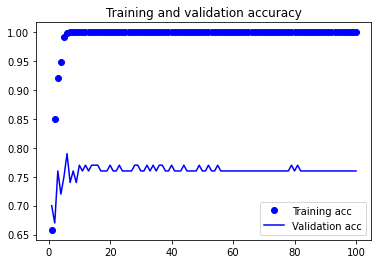

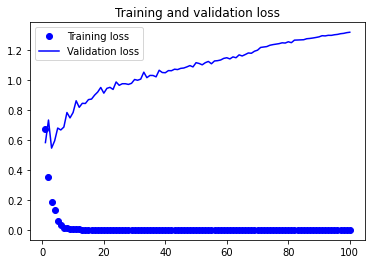

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:

from sklearn.metrics import accuracy_score

## Test Accuracy
predictions = model.predict(test_X)
ypred = predictions > 0.5
test_acc = accuracy_score(test_y, ypred)

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1score, _ = precision_recall_fscore_support(test_y, ypred, average='binary')

auc = roc_auc_score(test_y, ypred)

print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)


Train Accuracy:	 1.0
Val Accuracy:	 0.7599999904632568
Test Accuracy:	 0.8333333333333334
Precision:	 0.82
Recall:		 0.8541666666666666
F1 Score:	 0.836734693877551
AUC:		 0.8333333333333333


In [ ]:
model_resnet = ResNet50(include_top=True, weights=None,input_shape =None, classes = 1)
model_resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
model_resnet.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
history = model_resnet.fit(train_X, train_y,
                              batch_size=20,
                              epochs=100, 
                              validation_data=(val_X, val_y))

Epoch 1/100
25/25 [==============================] - 24s 579ms/step - loss: 1.3388 - acc: 0.5000 - val_loss: 0.8148 - val_acc: 0.5000
Epoch 2/100
25/25 [==============================] - 14s 555ms/step - loss: 0.6307 - acc: 0.5000 - val_loss: 0.8864 - val_acc: 0.5000
Epoch 3/100
25/25 [==============================] - 13s 534ms/step - loss: 0.5570 - acc: 0.5000 - val_loss: 0.9190 - val_acc: 0.5000
Epoch 4/100
25/25 [==============================] - 13s 533ms/step - loss: 0.6905 - acc: 0.5000 - val_loss: 0.7167 - val_acc: 0.5000
Epoch 5/100
25/25 [==============================] - 13s 531ms/step - loss: 0.5789 - acc: 0.5000 - val_loss: 0.8554 - val_acc: 0.5000
Epoch 6/100
25/25 [==============================] - 13s 531ms/step - loss: 0.5125 - acc: 0.5000 - val_loss: 0.9033 - val_acc: 0.5000
Epoch 7/100
25/25 [==============================] - 14s 551ms/step - loss: 0.4371 - acc: 0.5000 - val_loss: 0.7938 - val_acc: 0.5000
Epoch 8/100
25/25 [==============================] - 14s 552ms

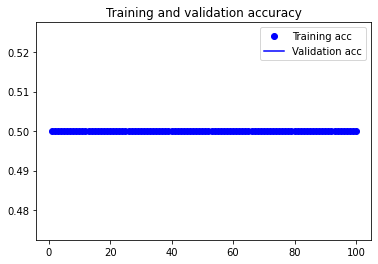

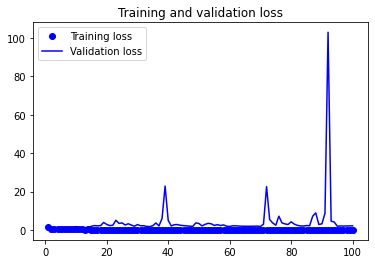

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

## Test Accuracy
predictions = model.predict(test_X)
ypred = predictions > 0.5
test_acc = accuracy_score(test_y, ypred)

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1score, _ = precision_recall_fscore_support(test_y, ypred, average='binary')

auc = roc_auc_score(test_y, ypred)

print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)

Train Accuracy:	 0.5
Val Accuracy:	 0.5
Test Accuracy:	 0.8333333333333334
Precision:	 0.82
Recall:		 0.8541666666666666
F1 Score:	 0.836734693877551
AUC:		 0.8333333333333333
